In [184]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [185]:
# ## Homework - Week 4  - Evaluation 
# In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

df = pd.read_csv("course_lead_scoring.csv")

df.head().T

# ### Data preparation
# * Check if the missing values are presented in the features.# Data preparation
    # Check if the missing values are presented in the features.

df.isnull().sum()
df.info() 

# * If there are missing values:
#     * For caterogiral features, replace them with 'NA'
#     * For numerical features, replace with with 0.0 

cat_features = list(df.dtypes[df.dtypes == 'object'].index)
print(cat_features)

for col in cat_features:
    df[col] = df[col].fillna('NA')

num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(num_features)

for col in num_features:
    df[col] = df[col].fillna(0)

df.isnull().sum()

# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

df_full_train, df_test =train_test_split(df, test_size=0.2, random_state=1)

df_train,df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
# split the df_train which was 80% of the original df as 0.25 * 0.80 = .20) 

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

 
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# For Q6
df_full_train = df_train
y_full_train = y_train 
 
del df_train['converted']
del df_val['converted']
del df_test['converted'] 

# # Initiate the model
# all_features = cat_features +  num_features
# # Seperate target variables in y_ series of dfs
# y_train = df_train["converted"].values
# y_val = df_val["converted"].values
# y_test = df_test["converted"].values


# # Drop target variable from dfs 
# df_train = df_train.drop(columns =["converted"])
# df_val = df_val.drop(columns=["converted"])
# df_test = df_test.drop(columns =["converted"])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB
['lead_source', 'industry', 'employment_status', 'location']
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']


In [186]:
# Length Check Before Continuing 
print(len(df))
print(len(df_full_train))
print(len(df_train))
print(len(df_test))   
print(len(df_val))

# Check and remove 'converted' from numerical features list
if 'converted' in num_features:
    num_features.remove('converted')
    
# Check and remove 'converted' from categorical features list if it was mistakenly there
if 'converted' in cat_features:
    cat_features.remove('converted')

# # Initiate the model
all_features = cat_features +  num_features

1462
876
876
293
293


In [187]:
# ### Question 1: ROC AUC feature importance
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from collections import (Counter)

# ROC AUC could also be used to evaluate feature importance of numerical variables. # Let's do that
# * For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
# * Use the training dataset for that

auc_scores = {}

for col in num_features:
    # Use the numerical variable as the prediction score
    y_pred = df_train[col].values

    # Calculate AUC
    auc = roc_auc_score(y_train, y_pred)

# If your AUC is < 0.5, invert this variable by putting "-" in front
# (e.g. `-df_train['balance']`)

    # Invert the score if AUC < 0.5
    if auc < 0.5:
        y_pred = -y_pred
        auc = roc_auc_score(y_train, y_pred)

    auc_scores[col] = round(auc,3)

# Find the variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)

print(auc_scores)
print(f"The numerical variable with the highest AUC is: {best_feature}")


# AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
# Which numerical variable (among the following 4) has the highest AUC?
    # - `lead_score`
            # - `number_of_courses_viewed`   ----  largest at 0.761
    # - `interaction_count`
    # - `annual_income`

    

{'number_of_courses_viewed': 0.761, 'annual_income': 0.538, 'interaction_count': 0.72, 'lead_score': 0.626}
The numerical variable with the highest AUC is: number_of_courses_viewed


In [188]:
# ### Question 2: Training the model

# Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

# ```python
# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# ```

train_dicts = df_train[all_features].to_dict(orient='records') # For making dict row-wise we use orient='records'
val_dicts = df_val[all_features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
# Predict on validation set
y_pred = model.predict_proba(X_val)[:, 1]

# y_pred = model.predict(X_val) -- only used when we need a 'hard' prediction in int, either 0 or 1 

# Calculate AUC on validation set
auc_val = roc_auc_score(y_val, y_pred)

print(f"Validation AUC: {auc_val:.3f}")

len(df_test)
len(df_val)

# What's the AUC of this model on the validation dataset? (round to 3 digits)
    # - 0.32
    # - 0.52
     # - 0.72  - I guess this one is closest? 
    # - 0.92




Validation AUC: 0.804


293

In [189]:
# Set the decision threshold
t = 0.5 

# --- 1. Define Actuals and Predictions ---
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

# --- 2. Calculate Confusion Matrix Components (Counts) ---
tp = (predict_positive & actual_positive).sum() # True Positives
tn = (predict_negative & actual_negative).sum() # True Negatives
fp = (predict_positive & actual_negative).sum() # False Positives
fn = (predict_negative & actual_positive).sum() # False Negatives

print(f"TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")

# --- 3. Calculate TPR and FPR (Rates) ---

# TPR (True Positive Rate) or Recall: Fraction of actual positives correctly identified
tpr = tp / (tp + fn) 

# FPR (False Positive Rate): Fraction of actual negatives incorrectly identified as positive
fpr = fp / (fp + tn) 

print(f"\nTPR (Recall) at t={t}: {tpr:.4f}")
print(f"FPR at t={t}: {fpr:.4f}")

TP: 166, FN: 15, FP: 64, TN: 48

TPR (Recall) at t=0.5: 0.9171
FPR at t=0.5: 0.5714


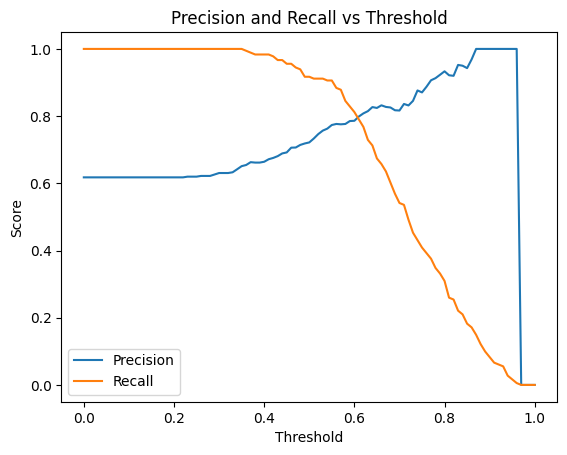

0.97


In [190]:
# ### Question 3: Precision and Recall

# Now let's compute precision and recall for our model.
# * Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

thresholds = np.linspace(0.0, 1.0, 101)
scores = []

# * For each threshold, compute precision and recall
for t in thresholds:
    y_pred_t = (y_pred >= t)
    p = precision_score(y_val, y_pred_t, zero_division=0)
    r = recall_score(y_val, y_pred_t, zero_division=0)
    scores.append({'threshold':t, 'precision':p, 'recall':r})

# Convert the list of dictionaries 'scores' into the DataFrame 'df_scores'
df_scores = pd.DataFrame(scores)

# * Plot them
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.show()

# Find the intersection point
# The intersection is where abs(precision - recall) is minimized
df_scores['diff'] = np.abs(df_scores['precision'] - df_scores['recall'])
intersection_threshold = df_scores.loc[df_scores['diff'].idxmin(), 'threshold']

print(intersection_threshold)

# print(f"Threshold where Precision and Recall intersect: {intersection_threshold:.3f}")
# At which threshold precision and recall curves intersect?
# * 0.145
# * 0.345
# * 0.545
# * 0.745

In [191]:
# ### Question 4: F1 score

# Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
# This is the formula for computing F1:
    # $$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$
    # Where $P$ is precision and $R$ is recall.
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
# Note: np.divide is used to safely handle division by zero (result is set to 0 where P+R=0)

numerator = 2 * df_scores['precision'] * df_scores['recall']
denominator = df_scores['precision'] + df_scores['recall']

df_scores['f1'] = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

max_f1_threshold = df_scores.loc[df_scores['f1'].idxmax(), 'threshold']

print(f"Threshold where F1 score is maximal: {max_f1_threshold:.2f}")

# At which threshold F1 is maximal?
# - 0.14
# - 0.34
    # - 0.54 - this is the closest answer 
# - 0.74

Threshold where F1 score is maximal: 0.55


In [192]:
# ### Question 5: 5-Fold CV
# Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

# ```
# KFold(n_splits=5, shuffle=True, random_state=1)
# ```

# * Iterate over different folds of `df_full_train`
# * Split the data into train and validation
# * Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
# * Use AUC to evaluate the model on validation

def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    # Create 101 thresholds from 0.0 to 1.0 (step 0.01)
    thresholds = np.linspace(0, 1, 101) 

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # Confusion Matrix Components
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    # Calculate Rates
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn) # TPR (Recall)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn) # FPR 
    
    return df_scores

# Run the function on our model's predictions
df_scores = tpr_fpr_dataframe(y_val, y_pred)


from sklearn.metrics import auc

# Calculate AUC using the trapezoidal rule on the manually generated FPR and TPR columns
manual_auc = auc(df_scores.fpr, df_scores.tpr)

print(f"Manually calculated AUC : {manual_auc:.4f}")


# How large is standard deviation of the scores across different folds?

# - 0.0001
# - 0.006
# - 0.06
# - 0.36

Manually calculated AUC : 0.8048


In [193]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

n_splits = 5
C_values = [0.000001, 0.001, 1]

# KFold splits the indices of the full training set
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for C in tqdm(C_values):
    scores = []
    
    # Iterate through the indices provided by kfold.split
    # Note: we use the original df_full_train and y_full_train
    for train_idx, val_idx in kfold.split(df_full_train):
        
        # Use .iloc[] to select the correct feature subsets
        df_train_k = df_full_train.iloc[train_idx]
        df_val_k = df_full_train.iloc[val_idx]

        # Use the indices to select the correct target subsets
        y_train_k = y_full_train[train_idx]
        y_val_k = y_full_train[val_idx]

        # Train and Predict using your functions
        dv, model = train(df_train_k, y_train_k, C=C)
        y_pred = predict(df_val_k, dv, model)

        auc = roc_auc_score(y_val_k, y_pred)
        scores.append(auc)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"C={C}: AUC mean = {mean_score:.3f} +- {std_score:.3f}")

100%|██████████| 3/3 [00:00<00:00, 11.61it/s]

C=1e-06: AUC mean = 0.544 +- 0.056
C=0.001: AUC mean = 0.865 +- 0.018
C=1: AUC mean = 0.819 +- 0.029


In [194]:
# ### Question 6: Hyperparameter Tuning

from tqdm.auto import tqdm
from sklearn.model_selection import KFold

# Now let's use 5-Fold cross-validation to find the best parameter `C`

# * Iterate over the following `C` values: `[0.000001, 0.001, 1]`
# * Initialize `KFold` with the same parameters as previously
# * Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
# * Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


def train(df_train, y_train, C=1.0):
    # 'all_features' needs to be defined as the combination of categorical and numerical features
    all_features = cat_features + num_features
    dicts = df_train[all_features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    all_features = cat_features + num_features
    dicts = df[all_features].to_dict(orient='records')
    X = dv.transform(dicts)
    # Get the probability of the positive class (churn/converted)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred


# ---------------------------------------------------

n_splits = 5
C_values = [0.000001, 0.001, 1]
results = {}

# Ensure the full training data has the target variable 'converted' for CV
df_full_train_cv = df_full_train.copy()
df_full_train_cv['converted'] = y_full_train 

for C in tqdm(C_values):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train_cv):
        df_train_k = df_full_train_cv.iloc[train_idx].drop(columns=['converted'])
        df_val_k = df_full_train_cv.iloc[val_idx].drop(columns=['converted'])

        y_train_k = df_full_train_cv.iloc[train_idx]['converted'].values
        y_val_k = df_full_train_cv.iloc[val_idx]['converted'].values

        dv, model = train(df_train_k, y_train_k, C=C)
        y_pred = predict(df_val_k, dv, model)

        auc = roc_auc_score(y_val_k, y_pred)
        scores.append(auc)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results[C] = {'mean_auc': mean_score, 'std_auc': std_score}

    print(f"C={C}: AUC mean = {mean_score:.3f} +- {std_score:.3f}")


# Which `C` leads to the best mean score?
# - 0.000001
    # - 0.001  - the highest AUC mean of 00865 
# - 1

# If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

 67%|██████▋   | 2/3 [00:00<00:00,  5.95it/s]

C=1e-06: AUC mean = 0.544 +- 0.056
C=0.001: AUC mean = 0.865 +- 0.018


100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

C=1: AUC mean = 0.819 +- 0.029


Starting Cross-Validation to collect ROC data...


 67%|██████▋   | 2/3 [00:00<00:00, 11.29it/s]

C=1e-06: Mean AUC = 0.544 +- 0.056
C=0.001: Mean AUC = 0.865 +- 0.018
C=1: Mean AUC = 0.819 +- 0.029

100%|██████████| 3/3 [00:00<00:00, 10.41it/s]

<bound method _AxesBase.set_aspect of <Axes: title={'center': 'ROC Curve for Different Regularization Parameters (C)'}, xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR) / Recall'>>

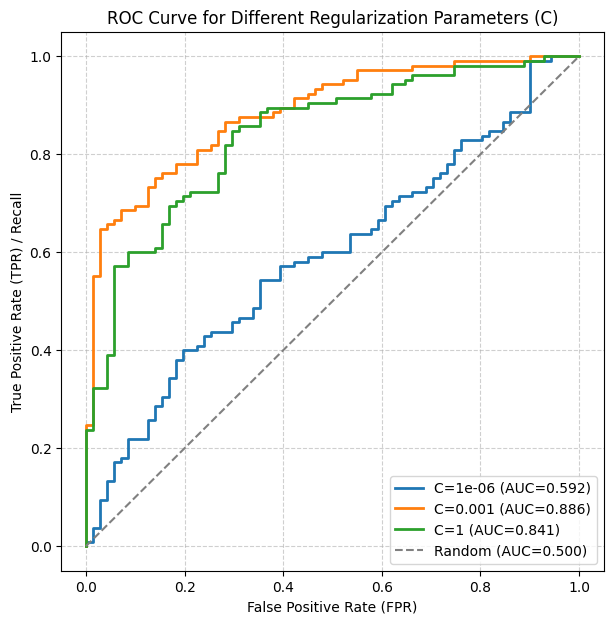

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
from tqdm.auto import tqdm

C_values = [0.000001, 0.001, 1]
n_splits = 5

# Dictionary to store (FPR, TPR, AUC) for plotting
roc_data = {}

# KFold splitter
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

print("Starting Cross-Validation to collect ROC data...")

# We iterate through the C values and only use the results from the first fold
for C in tqdm(C_values):
    scores = []
    
    # Run the KFold split. We only care about the first fold (i=0)
    for i, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        
        df_train_k = df_full_train.iloc[train_idx]
        df_val_k = df_full_train.iloc[val_idx]

        y_train_k = y_full_train[train_idx]
        y_val_k = y_full_train[val_idx]

        # Train and Predict
        # Note: You must ensure your 'train' and 'predict' functions are defined correctly
        dv, model = train(df_train_k, y_train_k, C=C)
        y_pred = predict(df_val_k, dv, model)

        auc_score = roc_auc_score(y_val_k, y_pred)
        scores.append(auc_score)
        
        # Only store the data for the first fold (i=0) to generate the curve
        if i == 0:
            fpr, tpr, thresholds = roc_curve(y_val_k, y_pred)
            roc_data[C] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score}
            
    # Print mean AUC for verification (should match your previous answer)
    print(f"C={C}: Mean AUC = {np.mean(scores):.3f} +- {np.std(scores):.3f}")


# --- Plotting the ROC Curves ---
plt.figure(figsize=(7, 7))

for C, data in roc_data.items():
    # Format the label to include the C value and the AUC from this fold
    label = f'C={C} (AUC={data["auc"]:.3f})'
    plt.plot(data['fpr'], data['tpr'], label=label, linewidth=2)

# Plot the baseline (random) model
plt.plot([0, 1], [0, 1], label='Random (AUC=0.500)', linestyle='--', color='gray')

# Add titles and labels
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve for Different Regularization Parameters (C)')
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.6)
plt.gca().set_aspect
